# Model instanciation
We want to try out the U-shape model created by Peng et al. (2022).

In [5]:
from divevision.models.UShapeTransformer.Ushape_Trans import Generator as UshapeModel
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# Instanciate model
model = UshapeModel()
model.load_state_dict(
    torch.load(
        "../models/UShapeTransformer/saved_models/G/generator_795.pth", 
        weights_only=True,
    )
)
model.to(device)
# Set model in inference mode
model.eval()

Generator(
  (linear_encoding): Linear(in_features=384, out_features=512, bias=True)
  (position_encoding): LearnedPositionalEncoding()
  (pe_dropout): Dropout(p=0.0, inplace=False)
  (transformer): TransformerModel(
    (net): IntermediateSequential(
      (0): Residual(
        (fn): PreNormDrop(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (fn): SelfAttention(
            (qkv): Linear(in_features=512, out_features=1536, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=512, out_features=512, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (1): Residual(
        (fn): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=512, out_features=256, bias=True)
           

# Data loading
We expect data to be loaded in the folder 'divevision/data' folder. In this example, we have loaded the [LSUI dataset](https://drive.google.com/file/d/10gD4s12uJxCHcuFdX9Khkv37zzBwNFbL/view?usp=sharing) consisting of 5k+ pairs of images.

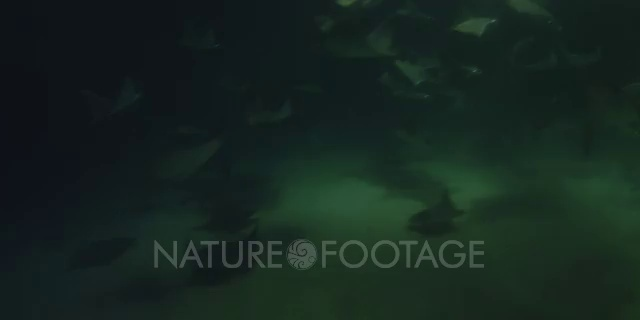

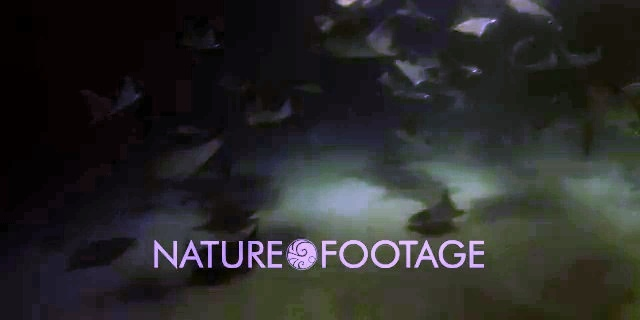

In [6]:
import random
import numpy as np
from pathlib import Path
from PIL import Image

dataset_location = "../data/LSUI/"
subfolders = {"GT", "input"}
MAX_INDEX = 5039

def load_image_as_np_array(image_location: str) -> np.ndarray:
    # Test that the path exists
    path = Path(image_location).resolve()
    if not path.exists():
        raise FileExistsError(f"No file found at {path}")
    
    # Load the image
    return Image.open(image_location)


def select_pair_of_images(index: int) -> tuple[Image, Image]: # type: ignore
    # Test that the index is valid
    if index > MAX_INDEX or index < 0:
        raise ValueError
    
    # Compute the images location
    image_location = map(
        lambda folder: f"{dataset_location}{folder}/{index}.jpg",
        subfolders
    )

    # Load the images
    return tuple(
        map(load_image_as_np_array, image_location)
    )

truth, original = select_pair_of_images(0)

display(original)
display(truth)

# Inference

In [7]:
import torch
from torchvision import transforms

def preprocess_image(
        image: Image,
        expected_size: tuple[int, int] = (256, 256),
    ) -> torch.Tensor:
    # Convert the image to a tensor
    tensor = transforms.PILToTensor()(image)
    # Resize the image to expected_size
    tensor = transforms.Resize(expected_size)(tensor)
    # Normalize data from [0,255] to [0,1]
    tensor = transforms.ConvertImageDtype(torch.float)(tensor)
    # Add a batch dimension to the tensor
    tensor = torch.unsqueeze(tensor, dim=0)
    return tensor

print(f"Original image shape: {original.size}")
tensor = preprocess_image(original)
print(f"Preprocessed tensor shape: {tensor.shape}")

tensor = tensor.to(device)

output = model(tensor)
infered_image = output[3].data

print(f"Infered image shape: {infered_image.shape}")

Original image shape: (640, 320)
Preprocessed tensor shape: torch.Size([1, 3, 256, 256])
Infered image shape: torch.Size([1, 3, 256, 256])


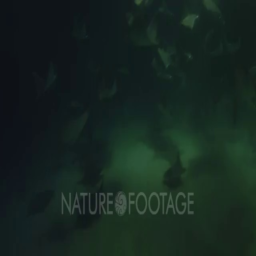

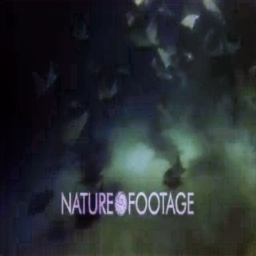

In [8]:
def postprocess_image(
    tensor: torch.Tensor,
) -> Image:

    # Remove the batch dimension
    tensor = torch.squeeze(tensor)
    # Clip data between [0,1]
    tensor = tensor.clip(0., 1.)
    # Convert to PIL image
    image = transforms.ToPILImage()(tensor)
    return image

display(postprocess_image(tensor))
display(postprocess_image(infered_image))

In [9]:
x = np.asarray(preprocess_image(original).squeeze().permute((1, 2, 0)))
y = np.asarray(infered_image.cpu().squeeze().clip(0, 1).permute((1, 2, 0)))

try:
    assert (x==y).all()
except:
    print("The preprocessed tensor is not strictly identical to the original!")
    print(f"Difference pixel-wise: {np.sum(np.abs((x - y)))}")

The preprocessed tensor is not strictly identical to the original!
Difference pixel-wise: 15602.58984375


# Metrics
To compare the quality of images, we can use metrics like PSNR and SSIM.

In [10]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def compute_psnr(image1: np.ndarray, image2: np.ndarray) -> float:
    """Compute Peak Signal to Noise Ratio (PSNR) between two images"""
    return psnr(image1, image2, data_range=1)

def compute_ssim(image1: np.ndarray, image2: np.ndarray, **kwargs) -> float:
    """Compute Structural Similarity Index Metric (SSIM) between two images"""
    return ssim(image1, image2, channel_axis=2, data_range=1)

print(f"PSNR between original and infered images: {compute_psnr(x, y)}")
print(f"SSIM between original and infered images: {compute_ssim(x, y)}")

PSNR between original and infered images: 18.709657874708466
SSIM between original and infered images: 0.7506792545318604
